# Benötigte Pakete
pandas: Für Arbeit mit ph_verlaufframe\
matplotlib: Zur Ausgabe von Plots und für Datenrechnungen\
holidays: Datensätze für Feiertage

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays

# Begrüßung User

In [8]:
print("""Willkommen zur Parkhausverfügbarkeitsprognose.
Im ersten Schritt können Sie einige Filterungen vornehmen.
Danach zeigen wir Ihnen passende Parkhäuser, die zur Auswahl stehen.
Sie suchen sich dann anhand des Kürzels ein Parkhaus aus.
Im Anschluss erhalten Sie die Prognose des ausgewählten Parkhauses für die nächste Woche.""")

Willkommen zur Parkhausverfügbarkeitsprognose.
Im ersten Schritt können Sie einige Filterungen vornehmen.
Danach zeigen wir Ihnen passende Parkhäuser, die zur Auswahl stehen.
Sie suchen sich dann anhand des Kürzels ein Parkhaus aus.
Im Anschluss erhalten Sie die Prognose des ausgewählten Parkhauses für die nächste Woche.


# Filterung
Im ersten Schritt kann der User drei Filterungen von Parkhauseigenschaften vornehmen:
1. Ladesäule vorhanden
2. Aufzug vorhanden
3. Mindestdurchfahrtshöhe des Parkhauses

In [9]:
# Datensatz zu Parkhauseigenschaften einlesen
ph_eigenschaften = pd.read_csv("../data/meta_data.csv")

# Filterung Ladesäule
ladesaeule_filter = input("Muss das gewünschte Parkhaus eine Ladesäule besitzen? 1: Ja, 0: Nein")
if (ladesaeule_filter in ["1", "Ja", "ja"]):
    ph_eigenschaften = ph_eigenschaften[ph_eigenschaften['Ladestation'] == True]
elif (ladesaeule_filter in ["0", "Nein", "Ne", "nein", "ne"]):
    pass
else: 
    print("Falsche Angabe bei der Ladesäule. Keine Filterung vorgenommen.")

# Filterung Aufzug
aufzug_filter = input("Muss das gewünschte Parkhaus einen Aufzug besitzen? 1: Ja, 0: Nein")
if (aufzug_filter in ["1", "Ja", "ja"]):
    ph_eigenschaften = ph_eigenschaften[ph_eigenschaften['Aufzug'] == True]
elif (aufzug_filter in ["0", "Nein", "Ne", "nein", "ne"]):
    pass
else: 
    print("Falsche Angabe beim Aufzug. Keine Filterung vorgenommen.")

# Filterung Mindestdurchfahrtshöhe
try:
    dh_filter = float(input("Welche Durchfahrtshöhe soll das Parkhaus mindestens haben? Angabe in cm (z. B. 160): "))
    ph_eigenschaften = ph_eigenschaften[ph_eigenschaften['Durchfahrtshoehe'] >= dh_filter]
except ValueError:
    print("Falsche Angabe bei der Mindestdurchfahrtshöhe. Bitte geben Sie einen numerischen Wert ein.")

# Parkhausauswahl
Nach den Filterungen wird dem User nun eine Liste aller passenden Parkhäuser angezeigt.<br>
Er kann nun durch Angabe des entsprechenden Kürzels ein Parkhaus auswählen. <br>
Danach laden wir dem Parkhaus entsprechende csv-Datei.

In [10]:
# Ausgabe der Liste mit passenden Parkhäusern
print("Folgende Parkhäuser entsprechen ihren Filterungen:")
for index, row in ph_eigenschaften.iterrows():
    parkhaus_info = "{kuerzel}: {name}, Durchfahrtshöhe {hoehe}cm, {behinderten} Behindertenstellplätze vorhanden".format(
        kuerzel=row["Parkhauskuerzel"],
        name=row["Parkhausname"],
        hoehe=row["Durchfahrtshoehe"],
        behinderten=row["Behindertenstellplaetze"],
    )
    print(parkhaus_info)

# Auswahl
while True:
    ph_kuerzel = input(
        "Sie können nun einen Parkhaus auswählen. Bitte geben Sie das entsprechende Parkhaus-Kürzel an (z. B. K01): "
    )

    # Überprüfung, ob das eingegebene Kürzel in der Liste der gefilterten Parkhäuser enthalten ist
    if ph_kuerzel in ph_eigenschaften["Parkhauskuerzel"].values:
        break
    else:
        print("Falsche Eingabe. Bitte geben Sie ein zu den Filterungen passendes Parkhaus-Kürzel ein.")


# Laden der entsprechenden csv-Datei des ausgewählten Parkhauses
ph_verlauf = pd.read_csv("../data/" + ph_kuerzel + ".csv")

Folgende Parkhäuser entsprechen ihren Filterungen:
K02: Kongresszentrum PH2, Durchfahrtshöhe 190cm, 12 Behindertenstellplätze vorhanden
N05: Schlossplatz, Durchfahrtshöhe 200cm, 3 Behindertenstellplätze vorhanden
N07: Kronenplatz, Durchfahrtshöhe 210cm, 5 Behindertenstellplätze vorhanden
S01: Landesbibliothek, Durchfahrtshöhe 200cm, 2 Behindertenstellplätze vorhanden
S04: IHK, Durchfahrtshöhe 180cm, 4 Behindertenstellplätze vorhanden
S05: Marktplatz, Durchfahrtshöhe 200cm, 1 Behindertenstellplätze vorhanden
W03: Postgalerie, Durchfahrtshöhe 200cm, 10 Behindertenstellplätze vorhanden


Falsche Eingabe. Bitte geben Sie ein zu den Filterungen passendes Parkhaus-Kürzel ein.


# Prognoseberechnung
(anhand Mittelwert der free spots)<br>
<br>
Schritt 1: Aggregation der Anzahl freier Parkplätze auf Stunden\
Schritt 2: Neue Spalte "belegt", die Anzahl belegter Plätze angibt\
Schritt 3: Feiertage entfernen, damit Prognose nicht verfälscht\
Schritt 4: Mittelwert der Belegung auf Basis bisheriger Wochen berechnen

In [11]:
# ------------------------------------
# Schritt 1: Aggregation auf Stunden
# ------------------------------------
# Konvertierung ins datetime-Format
ph_verlauf["timestamp"] = pd.to_datetime(ph_verlauf["timestamp"])
# Abrunden auf die Stunde
ph_verlauf["timestamp_hour"] = ph_verlauf["timestamp"].dt.floor("H")

# Gruppieren nach Datum und abgerundeter Stunde, dann Mittelwert berechnen
ph_verlauf_hour = ph_verlauf.groupby(ph_verlauf["timestamp_hour"])["free_spots"].mean()
ph_verlauf_hour = ph_verlauf_hour.reset_index(name="average_free_spots")
ph_verlauf_hour = round(ph_verlauf_hour, 0)

# Test-Ausgabe vorhandene Daten als Liniendiagramm
# ph_verlauf_hour.sort_values('timestamp_hour', inplace=True)
# plt.plot(ph_verlauf_hour['timestamp_hour'], ph_verlauf_hour['average_free_spots'])
# plt.show()

# ------------------------------------
# Schritt 2: Neue Spalte "belegt"
# ------------------------------------
# Gesamtanzahl Parkplätze des ausgewählten Parkhauses extrahieren
gesamtanzahl = ph_eigenschaften[ph_eigenschaften["Parkhauskuerzel"] == ph_kuerzel][
    "Gesamtanzahl"
].iloc[0]
# Neue Spalte mit Anzahl belegter Parkplätze
ph_verlauf_hour["belegt"] = gesamtanzahl - ph_verlauf_hour["average_free_spots"]

# ------------------------------------
# Schritt 3: Feiertag(e) entfernen
# ------------------------------------

# Feiertage für Baden-Württemberg
bw_holidays = holidays.DE(subdiv="BW", years=2023)

# Datenpunkte an Feiertagen löschen, damit Prognose nicht verfälscht wird
ph_verlauf_hour["feiertag"] = ph_verlauf_hour["timestamp_hour"].dt.floor("D").isin(bw_holidays)
ph_verlauf_hour = ph_verlauf_hour[ph_verlauf_hour["feiertag"] == False]

# ------------------------------------
# Schritt 4: Mittelwert berechnen
# ------------------------------------

# Wochentag und Stunde extrahieren
ph_verlauf_hour["wochentag"] = ph_verlauf_hour["timestamp_hour"].dt.day_name()
ph_verlauf_hour["stunde"] = ph_verlauf_hour["timestamp_hour"].dt.hour

# Mittelwert der belegten Plätze, gruppiert nach Wochentag und Stunde
mittelwerte = (
    ph_verlauf_hour.groupby(["wochentag", "stunde"])["belegt"].mean().reset_index()
)
mittelwerte.rename(columns={"belegt": "mittelwert_belegt"}, inplace=True)

# Ausgabe als Liniendiagramm
Für jeden Tag eine Verlaufskurve in einem Liniendiagramm, sodass ein guter Vergleich möglich ist.
Zudem vorher der Hinweis, dass die Prognose auf Mittelwerten vergangener Wochen basiert und die Belegung
an Feiertagen und bei anderen Besonderheiten mitunter stark abweichen kann.

Im Folgenden ein Liniendiagramm mit erwarteter Auslastung nach Wochentagen und Uhrzeit.
Bitte beachten Sie, dass die Belegung an Feiertagen oder bei anderweitigen Besonderheiten wie z. B.
Straßensperrungen oder größeren Events auch stark abweichen kann.


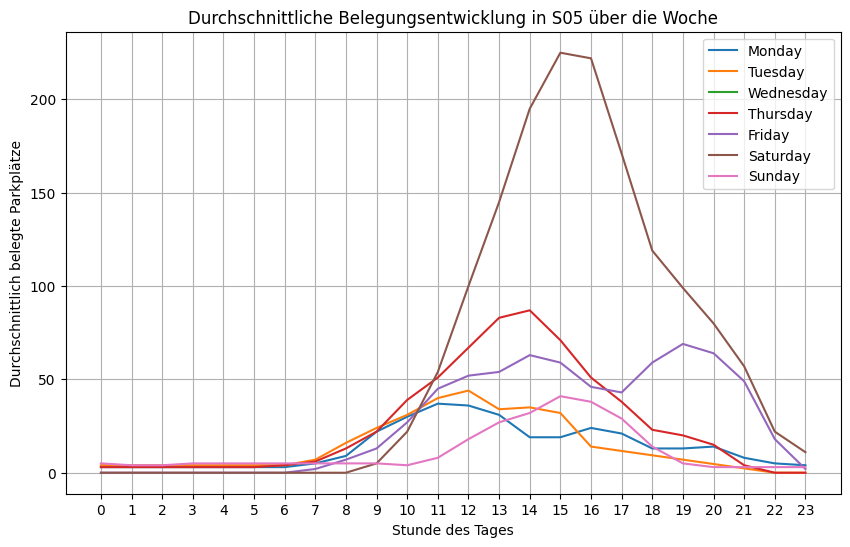

In [12]:
# Hinweis ausgeben
print("""Im Folgenden ein Liniendiagramm mit erwarteter Auslastung nach Wochentagen und Uhrzeit.
Bitte beachten Sie, dass die Belegung an Feiertagen oder bei anderweitigen Besonderheiten wie z. B.
Straßensperrungen oder größeren Events auch stark abweichen kann.""")

fig, ax = plt.subplots(figsize=(10, 6))

# Eindeutige Wochentage ermitteln
wochentage = mittelwerte['wochentag'].unique()

# Sortieren der Wochentage in der richtigen Reihenfolge
sortierte_wochentage = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Mittelwerte je Wochentag plotten
for wochentag in sortierte_wochentage:
    tagesdaten = mittelwerte[mittelwerte['wochentag'] == wochentag]
    ax.plot(tagesdaten['stunde'], tagesdaten['mittelwert_belegt'], label=wochentag)

# Achsenbeschriftungen und Diagrammtitel
ax.set_xlabel('Stunde des Tages')
ax.set_ylabel('Durchschnittlich belegte Parkplätze')
ax.set_title('Durchschnittliche Belegungsentwicklung in ' + ph_kuerzel + ' über die Woche')
ax.legend()

# Diagramm anzeigen mit Gitternetzlinien
ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24))
plt.grid(True)
plt.show()